In [1]:
import torch
from  torchvision import transforms,datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
from PIL import Image 
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
data = pd.read_csv('../input/digit-recognizer/train.csv')
x_train,x_test,y_train,y_test = train_test_split(data.iloc[:,1:],data.iloc[:,0],shuffle=False)

In [4]:
x_train.shape

(31500, 784)

In [5]:
# normalising the data
x_train = x_train/255.0
x_test = x_test/255.0
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

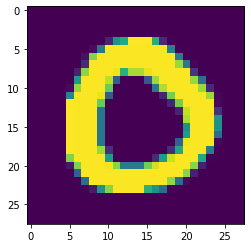

In [6]:
plt.imshow(np.array(x_train.iloc[4,:]).reshape(28,28))

In [7]:
#dataprep
class DataSet:
    def __init__(self,x_train,y_train,transform=None):
        self.img = x_train
        self.lab = y_train
        self.transform = transform
    def __len__(self):
        print(self.img.shape)
        return len(self.img)
    def __getitem__(self,idx):
        img = np.array(self.img.iloc[idx,:]).reshape(28,28)
        if self.transform:
            img = self.transform(img)
        lab = self.lab.iloc[idx]
        return lab,img

In [8]:
#transform the image of 28*28 to tensors and normalise it
convert = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Grayscale()
])

In [9]:
# loading the data
data = DataSet(x_train,y_train,transform =convert)
train_loader = torch.utils.data.DataLoader(data,batch_size=64)

(31500, 784)


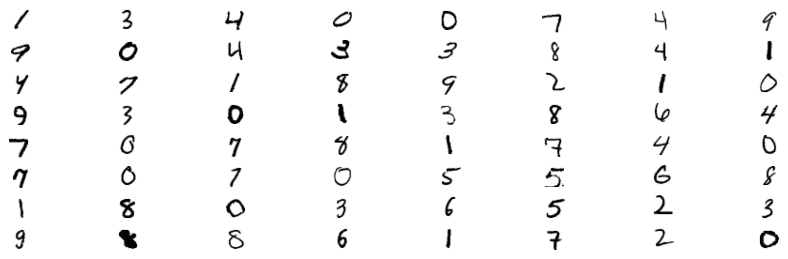

In [10]:
import matplotlib.pyplot as plt
# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))
try:
    for i,(lab,image) in enumerate(train_loader):  
        plt.subplot(8, 8, i+1)
    #     plt.title(f'{lab[i]}')
        plt.imshow(image[i].reshape(28,28),cmap = 'binary')
        plt.axis('off')
    plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
    plt.show()
except Exception as e:
    pass

In [11]:
class Net(nn.Module):
    def __init__(self,in_channel,out_channel,num_classes):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channel,6,(5,5),padding=2),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.5),
                                    nn.MaxPool2d(2,2))
        self.layer2 = nn.Sequential(nn.Conv2d(6,out_channel,5),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.3),
                                    nn.MaxPool2d(2,2))
        self.fc1 = nn.Linear(18*5*5,256)
        self.fc2 = nn.Linear(256,124)
        self.fc3 = nn.Linear(124,64)
        self.fc4 = nn.Linear(64,num_classes)
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1,18*5*5)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out

In [17]:

model = Net(in_channel=1,out_channel=18,num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.001)
TRAIN= True
checkpoint = torch.load('../input/catdogmodel/CatDogModel.pth')
model.load_state_dict(checkpoint)
losses = []

def Train():

    EPOCHS = 3
    for i in tqdm(range(EPOCHS)):
        for lab,img in train_loader:
            img = img.to(device).float()
            lab = lab.to(device)
    #         print(len(img))
            preds = model(img)
    #         print(preds)
            loss = criterion(preds,lab)
            losses.append(loss)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            torch.save(model.state_dict(),'model.pth')
        if i % 2==0:
            print(f'losses: {loss:.4f} at {i} EPOCH')
if TRAIN:
    Train()

  0%|          | 0/3 [00:00<?, ?it/s]

(31500, 784)


 33%|███▎      | 1/3 [00:08<00:16,  8.37s/it]

losses: 0.1667 at 0 EPOCH
(31500, 784)


 67%|██████▋   | 2/3 [00:17<00:08,  8.72s/it]

(31500, 784)


100%|██████████| 3/3 [00:26<00:00,  8.81s/it]

losses: 0.0130 at 2 EPOCH


### Testing the model on the Test set we seperated earlier from the train set

In [20]:
TEST = True
data = DataSet(x_test,y_test,transform =convert)
test_loader = torch.utils.data.DataLoader(data,batch_size=64)
checkpoint = torch.load('../input/catdogmodel/CatDogModel.pth',map_location=torch.device('cpu') ) 
model.load_state_dict(checkpoint)

def Test():
    with torch.no_grad():
        total = 10500
        model.eval()
        correct = 0
        for labels,images in tqdm(test_loader):
#             print(images)
            try:
                images = images.to(device).float()
                labels = labels.to(device)
                output = model(images)
                for i in  range(64):
                    prediction = torch.max(output[i],0)[1]#this returns value and prediction_index(which in this case is our no. output)
                    if prediction == labels[i]:
                        correct+=1
            except Exception as e:
                pass
        print(f'correct: {correct}')
        print(f'accuracy: {(correct/total)*100}')
                    
if TEST:
    Test()

  4%|▍         | 7/165 [00:00<00:02, 67.48it/s]

(10500, 784)
(10500, 784)


100%|██████████| 165/165 [00:02<00:00, 66.58it/s]

correct: 10363
accuracy: 98.6952380952381


#### the model predicted a 98% acc on test set

### Finally making predictions on the Validation set which will be used for final submission too 

In [18]:
#dataprep
class ValDataSet:
    def __init__(self,x_train,y_train=None,transform=None):
        self.img = x_train
        self.lab = y_train
        self.transform = transform
    def __len__(self):
        print(self.img.shape)
        return len(self.img)
    def __getitem__(self,idx):
        img = np.array(self.img.iloc[idx,:]).reshape(28,28)
        if self.transform:
            img = self.transform(img)
        if self.lab :
            lab = self.lab.iloc[idx]
            return lab,img
        return img

In [21]:
validation = pd.read_csv('../input/digit-recognizer/test.csv')
dataset = ValDataSet(validation,transform=convert)
val_loader = torch.utils.data.DataLoader(dataset,batch_size=64)
# taking predictions from the model
predictions = []
for img in tqdm(val_loader):
    img = img.to(device).float()
    
    preds = model(img)
#     print(preds)
    for i in  range(64):
        try:
            value = [torch.max(preds[i],-1)[1].item()]
    #         break
            predictions.extend(value)
        except Exception as e:
#the last batch is not having 64 values hence we tackle it with try statement              
            pass

  2%|▏         | 7/438 [00:00<00:06, 65.64it/s]

(28000, 784)
(28000, 784)


100%|██████████| 438/438 [00:06<00:00, 66.86it/s]


In [23]:
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [24]:
submission['Label'] = predictions
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [25]:
submission.to_csv('sub.csv',index=False)